News Article Classification
# Using Word2Vec + Logistic Regression + Random Forest

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
%pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 94.3 MB/s eta 0:00:00


In [ ]:
# Importing core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, string, warnings
from tqdm import tqdm
import nltk
# nltk.download('punkt') # Already downloaded
# nltk.download('stopwords') # Already downloaded
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from gensim.models import Word2Vec

In [ ]:
# Machine learning imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, classification_report
)

warnings.filterwarnings("ignore")
tqdm.pandas()

In [ ]:
# Load Dataset
print("Loading BBC News dataset...")
df = pd.read_csv("bbc_text_cls.csv")  # Ensure this CSV exists in your working dir
print(f" Dataset loaded with {df.shape[0]} records and {df.shape[1]} columns.\n")


print(df.head(3))

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows found: {duplicates}")
if duplicates > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicates removed.\n")

Loading BBC News dataset...
 Dataset loaded with 2225 records and 2 columns.

                                                text    labels
0  Ad sales boost Time Warner profit\n\nQuarterly...  business
1  Dollar gains on Greenspan speech\n\nThe dollar...  business
2  Yukos unit buyer faces loan claim\n\nThe owner...  business
Duplicate rows found: 98
Duplicates removed.



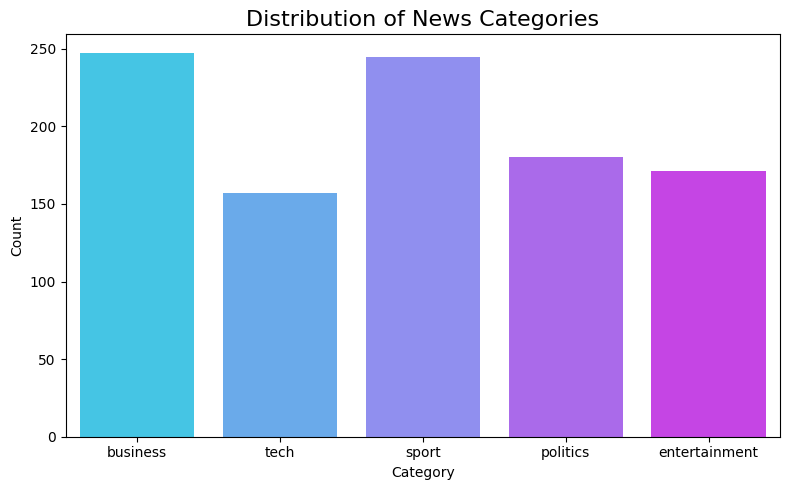

In [ ]:
#EDA
plt.figure(figsize=(8,5))
sns.countplot(x='labels', data=df_subset, palette='cool')
plt.title("Distribution of News Categories", fontsize=16)
plt.xlabel("Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
# text preprocessing
print("Cleaning and preparing text data...")

stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

def clean_text(text):
    """Lowercase, remove punctuation, stopwords, and apply stemming."""
    text = re.sub(r"[^a-zA-Z]", " ", text)
    tokens = word_tokenize(text.lower())
    tokens = [stemmer.stem(w) for w in tokens if w not in stop_words and len(w) > 2]
    return tokens

df_subset["tokens"] = df_subset["text"].progress_apply(clean_text)
print("Text cleaning complete.\n")


Cleaning and preparing text data...


100%|██████████| 1000/1000 [00:04<00:00, 228.50it/s]

Text cleaning complete.



In [ ]:
# Word2Vec Embeddings
print("Training Word2Vec model...")

w2v_model = Word2Vec(sentences=df_subset["tokens"], vector_size=30, window=5, min_count=2, workers=4, sg=1)
w2v_model.train(df_subset["tokens"], total_examples=len(df_subset["tokens"]), epochs=10)
print("Word2Vec model trained.\n")

# Helper function to get average word vectors
def get_vector(words, model, vector_size):
    word_vecs = [model.wv[w] for w in words if w in model.wv]
    if len(word_vecs) == 0:
        return np.zeros(vector_size)
    return np.mean(word_vecs, axis=0)

# Convert each text into a vector
print("Creating averaged word vectors...")
X = np.array([get_vector(tokens, w2v_model, 30) for tokens in tqdm(df_subset["tokens"])])

Training Word2Vec model...


Word2Vec model trained.

Creating averaged word vectors...


100%|██████████| 1000/1000 [00:00<00:00, 3002.41it/s]


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_subset["labels"])

In [ ]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Data split into training and testing sets.\n")


# Logistic Regression
print("Training Logistic Regression...")
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Random Forest
print("Training Random Forest Classifier...")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

print("Both models trained successfully.\n")

Data split into training and testing sets.

Training Logistic Regression...
Training Random Forest Classifier...
Both models trained successfully.



In [ ]:
# Evaluation Function

def evaluate_model(model, name):
    """Evaluate and display model performance metrics."""
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average='weighted')
    rec = recall_score(y_test, preds, average='weighted')

    print(f"--- {name} Evaluation ---")
    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}\n")
    print("Classification Report:\n", classification_report(y_test, preds, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

--- Logistic Regression Evaluation ---
Accuracy: 0.970
Precision: 0.972
Recall: 0.970

Classification Report:
                precision    recall  f1-score   support

     business       0.91      0.98      0.94        50
entertainment       1.00      1.00      1.00        34
     politics       0.97      0.92      0.94        36
        sport       1.00      1.00      1.00        49
         tech       1.00      0.94      0.97        31

     accuracy                           0.97       200
    macro avg       0.98      0.97      0.97       200
 weighted avg       0.97      0.97      0.97       200



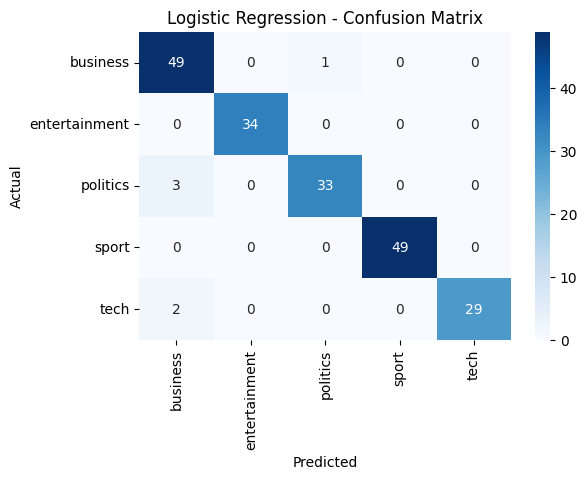

--- Random Forest Evaluation ---
Accuracy: 0.975
Precision: 0.976
Recall: 0.975

Classification Report:
                precision    recall  f1-score   support

     business       0.92      0.98      0.95        50
entertainment       1.00      1.00      1.00        34
     politics       0.97      0.94      0.96        36
        sport       1.00      1.00      1.00        49
         tech       1.00      0.94      0.97        31

     accuracy                           0.97       200
    macro avg       0.98      0.97      0.98       200
 weighted avg       0.98      0.97      0.98       200



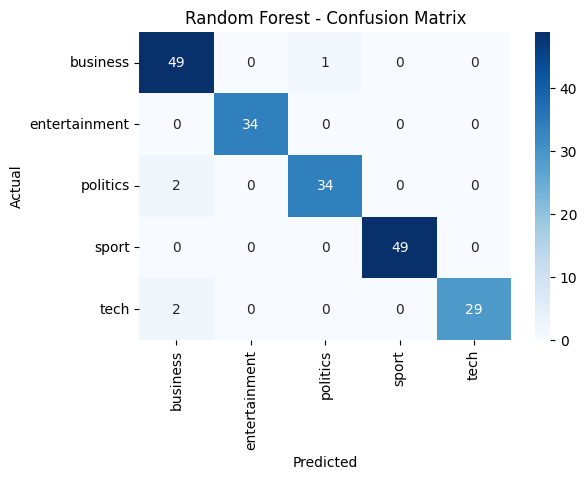

In [ ]:
# Model Evaluation
evaluate_model(log_reg, "Logistic Regression")
evaluate_model(rf_clf, "Random Forest")

In [ ]:
#Test the classifier on new text
def predict_category(text, w2v_model, model, label_encoder):
    # Clean text using same function as training
    tokens = clean_text(text)
    vector = get_vector(tokens, w2v_model, 100).reshape(1, -1)
    prediction = model.predict(vector)[0]
    category = label_encoder.inverse_transform([prediction])[0]
    return category

# Example test sentences
test_samples = [
    "The new iPhone 16 was launched with an improved camera and AI chip.",
    "Manchester United secured a dramatic victory in the Champions League.",
    "The Prime Minister addressed parliament about economic reforms.",
    "Netflix releases a new fantasy series this weekend."
]

for text in test_samples:
    category = predict_category(text, w2v_model, log_reg, label_encoder)
    print(f"📰 '{text}'\n→ Predicted category: {category}\n")


📰 'The new iPhone 16 was launched with an improved camera and AI chip.'
→ Predicted category: tech

📰 'Manchester United secured a dramatic victory in the Champions League.'
→ Predicted category: sport

📰 'The Prime Minister addressed parliament about economic reforms.'
→ Predicted category: politics

📰 'Netflix releases a new fantasy series this weekend.'
→ Predicted category: entertainment



In [ ]:
import pickle

with open("logistic_regression_model.pkl", "wb") as f:
    pickle.dump(log_reg, f)

with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(rf_clf, f)

w2v_model.save("bbc_word2vec.model")

print("\n All models saved successfully!")
print(" Project complete — BBC News classification pipeline ready.")


 All models saved successfully!
 Project complete — BBC News classification pipeline ready.
